# Imports

In [105]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from datetime import timedelta
import re
import optuna
import xgboost as xgb
from sklearn.datasets import load_diabetes

# Paths and Loading

In [106]:
DIR_PATH = ''

### Train and test dataset

In [107]:
df_original_name = 'sales_ads_train.csv'
df_test_name = 'sales_ads_test.csv'

In [108]:
df_original = pd.read_csv(DIR_PATH + '/' + df_original_name)
df_test = pd.read_csv(DIR_PATH + '/' + df_test_name)

### Additional dataset for imputation

In [109]:
df_otomoto_name = 'otomoto_offers_eng_23-04-2023.csv'

In [110]:
df_otomoto = pd.read_csv(DIR_PATH + '/' + df_otomoto_name, sep=';', usecols = ['offer_creation_date',
                         'price',
                         'currency',
                         'vehicle_brand',
                         'vehicle_model',
                         'generation',
                         'production_year',
                         'mileage',
                         'engine_displacement',
                         'fuel_type',
                         'power',
                         'transmission',
                         'number_of_seats',
                         'number_of_doors',
                         'version',
                         'body_type'])

# Changing types

In [111]:
import pandas as pd

def convert_column_types(df):

    datetime_cols = ["Data_pierwszej_rejestracji", "Data_publikacji_oferty"]
    categorical_cols = [
        "Stan", "Marka_pojazdu", "Wersja_pojazdu",
        "Rodzaj_paliwa", "Naped", "Skrzynia_biegow",
        "Typ_nadwozia", "Liczba_drzwi", "Kolor", "Kraj_pochodzenia",
        "Lokalizacja_oferty", "Wyposazenie", "Pierwszy_wlasciciel"
    ]
    numeric_cols = ["Rok_produkcji", "Przebieg_km", "Moc_KM", "Pojemnosc_cm3", "Emisja_CO2"]

    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', format="%d/%m/%Y")

    for col in categorical_cols:
         df[col] = df[col].astype('category')

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


In [112]:
df_original = convert_column_types(df_original)
df_test = convert_column_types(df_test)

# Data manipulation

### Wyposazenie

##### One-hot encoding on each unique element from "Wyposazenie"

In [113]:
df_original_wyposazenie = df_original.copy()
df_test_wyposazenie = df_test.copy()

In [114]:
df_original_wyposazenie["Wyposazenie"] = df_original_wyposazenie["Wyposazenie"].astype(str)
df_test_wyposazenie["Wyposazenie"] = df_test_wyposazenie["Wyposazenie"].astype(str)

df_original_wyposazenie["Wyposazenie"] = df_original_wyposazenie["Wyposazenie"].str.replace(r"[\[\]']", "", regex=True)
df_test_wyposazenie["Wyposazenie"] = df_test_wyposazenie["Wyposazenie"].str.replace(r"[\[\]']", "", regex=True)

In [115]:
feature_counts = {}

for features in df_original_wyposazenie["Wyposazenie"].str.split(", "):
    for feature in features:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1


feature_counts_df = pd.DataFrame(list(feature_counts.items()), columns=["Wyposażenie", "Counts"])
feature_counts_df = feature_counts_df.sort_values(by="Counts", ascending=False)


print(feature_counts_df.head(5))


               Wyposażenie  Counts
0                      ABS  118133
12         Central locking  117470
1   Electric front windows  115037
2           Drivers airbag  114554
3           Power steering  114405


In [116]:
encoded_features_original = pd.DataFrame(0, index=df_original_wyposazenie.index, columns=feature_counts_df["Wyposażenie"])
encoded_features_test = pd.DataFrame(0, index=df_test_wyposazenie.index, columns=feature_counts_df["Wyposażenie"])


for index, row in df_original_wyposazenie.iterrows():
    features = row["Wyposazenie"].split(", ")
    for feature in features:
        if feature in encoded_features_original.columns:
            encoded_features_original.at[index, feature] = 1


for index, row in df_test_wyposazenie.iterrows():
    features = row["Wyposazenie"].split(", ")
    for feature in features:
        if feature in encoded_features_test.columns:
            encoded_features_test.at[index, feature] = 1


df_original_wyposazenie_encoded = pd.concat([df_original_wyposazenie.drop(columns=["Wyposazenie"]), encoded_features_original], axis=1)
df_test_wyposazenie_encoded = pd.concat([df_test_wyposazenie.drop(columns=["Wyposazenie"]), encoded_features_test], axis=1)


In [117]:
df_original_wyposazenie_encoded["ABS"].value_counts()

,count
ABS,
1,118133
0,17264


### Waluta

##### Imputing missing values in "Waluta" by comparing the ("Cena") to median prices for the same Marka_pojazdu, Model_pojazdu, and Rok_produkcji, calculated  for PLN and EUR. And mapping to numeric format using "PLN" → 0 and "EUR" → 1.

In [118]:
df_original_waluta = df_original_wyposazenie_encoded.copy()
df_test_waluta = df_test_wyposazenie_encoded.copy()

In [119]:
mediana_eur = df_original[df_original['Waluta'] == 'EUR'].groupby(['Marka_pojazdu', 'Model_pojazdu', 'Rok_produkcji'], observed=False)['Cena'].median()
mediana_pln = df_original[df_original['Waluta'] == 'PLN'].groupby(['Marka_pojazdu', 'Model_pojazdu', 'Rok_produkcji'], observed=False)['Cena'].median()

KURS_EUR_PLN = 4.57

def przypisz_walute(row):
    if pd.isna(row['Waluta']):
        med_eur = mediana_eur.get((row['Marka_pojazdu'], row['Model_pojazdu'], row['Rok_produkcji']), None)
        med_pln = mediana_pln.get((row['Marka_pojazdu'], row['Model_pojazdu'], row['Rok_produkcji']), None)

        if med_eur is not None and med_pln is not None:
            cena_eur_w_pln = med_eur * KURS_EUR_PLN
            cena_pln_w_eur = med_pln / KURS_EUR_PLN

            if abs(row['Cena'] - cena_eur_w_pln) < abs(row['Cena'] - med_pln):
                return 'EUR'
            else:
                return 'PLN'

        elif med_eur is not None:
            return 'EUR' if row['Cena'] < (med_eur * KURS_EUR_PLN) else 'PLN'

        elif med_pln is not None:
            return 'PLN' if row['Cena'] > (med_pln / KURS_EUR_PLN) else 'EUR'

        return 'PLN'

    return row['Waluta']

In [120]:
print(df_original_waluta['Waluta'].value_counts(dropna=False))
df_original_waluta['Waluta'] = df_original_waluta.apply(przypisz_walute, axis=1)

print('=================================================')

print(df_original_waluta['Waluta'].value_counts(dropna=False))

Waluta
PLN    131856
NaN      3376
EUR       165
Name: count, dtype: int64
Waluta
PLN    135169
EUR       228
Name: count, dtype: int64


In [121]:
df_original_waluta['Waluta'] = df_original_waluta["Waluta"].map({"PLN": 0, "EUR": 1})
df_test_waluta["Waluta"] = df_test_waluta["Waluta"].map({"PLN": 0, "EUR": 1})

In [122]:
print(df_original_waluta['Waluta'].value_counts(dropna=False))

Waluta
0    135169
1       228
Name: count, dtype: int64


### Stan

#### Mapping to numeric format using "Used" → 0 and "New" → 1, simple imputation and deleting nonsense rows

In [123]:
df_original_stan = df_original_waluta.copy()
df_test_stan = df_test_waluta.copy()

In [124]:
df_original_stan.loc[df_original_stan["Przebieg_km"] <= 5, "Stan"] = "New"
df_original_stan.loc[df_original_stan["Przebieg_km"] > 10_000, "Stan"] = "Used"

df_test_stan.loc[df_test_stan["Przebieg_km"] <= 5, "Stan"] = "New"
df_test_stan.loc[df_test_stan["Przebieg_km"] > 10_000, "Stan"] = "Used"

In [125]:
df_original_stan["Stan"] = df_original_stan["Stan"].map({"Used": 0.0, "New": 1.0})
df_test_stan["Stan"] = df_test_stan["Stan"].map({"Used": 0.0, "New": 1.0})

In [126]:
max_used_idx = df_original_stan.loc[df_original_stan["Stan"] == 0.0, "Cena"].idxmax()
min_new_idx = df_original_stan.loc[df_original_stan["Stan"] == 1.0, "Cena"].idxmin()

df_original_stan.drop([max_used_idx, min_new_idx], inplace=True)

In [127]:
df_original_stan["Stan"] = df_original_stan["Stan"].astype(object).astype(float)
df_test_stan["Stan"] = df_test_stan["Stan"].astype(object).astype(float)

In [128]:
print(df_original_stan['Stan'].value_counts(dropna=False))

Stan
0.0    118213
1.0     16858
NaN       324
Name: count, dtype: int64


### Model samocochodu

#### Imputting missing values in "Model_pojazdu"  based on the most frequent model for each combination of vehicle brand and generation from an external reference dataset. Applying target encoding reflecting its typical market value.

In [129]:
df_original_model = df_original_stan.copy()
df_test_model = df_test_stan.copy()

In [130]:
df_original_model["Model_pojazdu"].isna().sum()

np.int64(3309)

In [131]:
df_otomoto_clean = df_otomoto.dropna(subset=['generation', 'vehicle_model', 'vehicle_brand'])

mapping_gen_marka_to_model = (
    df_otomoto_clean
    .groupby(['vehicle_brand', 'generation'])['vehicle_model']
    .agg(lambda x: x.mode()[0])
    .to_dict()
)

In [132]:
mask_missing_model = df_original_model['Model_pojazdu'].isna()

df_original_model.loc[mask_missing_model, 'Model_pojazdu'] = df_original_model.loc[mask_missing_model].apply(
    lambda row: mapping_gen_marka_to_model.get((row['Marka_pojazdu'], row['Generacja_pojazdu'])),
    axis=1
)

In [133]:
num_imputed = mask_missing_model.sum() - df_original_model.loc[mask_missing_model, 'Model_pojazdu'].isna().sum()
print(f"Imputted {num_imputed} missing models")

Imputted 1901 missing models


In [134]:
mask_complete = (
    df_original_model["Model_pojazdu"].notna() &
    df_original_model["Marka_pojazdu"].notna() &
    df_original_model["Cena"].notna()
)

model_brand_median_price = df_original_model[mask_complete].groupby(
    ["Model_pojazdu", "Marka_pojazdu"]
)["Cena"].median()

model_brand_mean_price = df_original_model[mask_complete].groupby(
    ["Model_pojazdu", "Marka_pojazdu"]
)["Cena"].mean()

brand_median_price = df_original_model[mask_complete].groupby("Marka_pojazdu")["Cena"].median()
brand_mean_price = df_original_model[mask_complete].groupby("Marka_pojazdu")["Cena"].mean()

global_median_price = df_original_model["Cena"].median()
global_mean_price = df_original_model["Cena"].mean()

<ipython-input-134-b9aeda14a3d2>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_brand_median_price = df_original_model[mask_complete].groupby(
<ipython-input-134-b9aeda14a3d2>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_brand_mean_price = df_original_model[mask_complete].groupby(
<ipython-input-134-b9aeda14a3d2>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_median_price = df_original_model[m

In [135]:
def encode_model(row):
    model, brand = row["Model_pojazdu"], row["Marka_pojazdu"]

    if (model, brand) in model_brand_median_price.index and (model, brand) in model_brand_mean_price.index:
        return (model_brand_median_price[(model, brand)] + model_brand_mean_price[(model, brand)]) / 2

    elif brand in brand_median_price and brand in brand_mean_price:
        return (brand_median_price[brand] + brand_mean_price[brand]) / 2


    return (global_median_price + global_mean_price) / 2

In [136]:
df_original_model["Model_pojazdu_encoded"] = df_original_model.apply(encode_model, axis=1)
df_test_model["Model_pojazdu_encoded"] = df_test_model.apply(encode_model, axis=1)

In [137]:
print(df_original_model['Model_pojazdu_encoded'].describe())

count    1.353950e+05
mean     5.712091e+04
std      6.268119e+04
min      1.250000e+03
25%      2.616247e+04
50%      4.050529e+04
75%      6.717259e+04
max      2.100000e+06
Name: Model_pojazdu_encoded, dtype: float64


### Marka samocochodu

#### Imputing missing values in "Marka_pojazdu" by mapping each "Model_pojazdu" to the most frequent brand associated with it in the combined dataset. Target encoding is applied by assigning each brand a numeric value based on the average of its median and mean prices from the training set, with unknown brands in the test set receiving a global fallback value.

In [138]:
df_original_marka = df_original_model.copy()
df_test_marka = df_test_model.copy()

In [139]:
def imputting_marka_based_on_model(df_train, df_test):
    df_both = pd.concat([df_train, df_test], axis=0).dropna(subset=['Marka_pojazdu', 'Model_pojazdu'])

    model_to_brand = (
        df_both
        .groupby('Model_pojazdu', observed=False)['Marka_pojazdu']
        .agg(lambda x: x.value_counts().index[0])
    )

    mask_brand_missing_train = df_train['Marka_pojazdu'].isna() & df_train['Model_pojazdu'].notna()
    df_train.loc[mask_brand_missing_train, 'Marka_pojazdu'] = df_train.loc[mask_brand_missing_train, 'Model_pojazdu'].map(model_to_brand)

    mask_brand_missing_test = df_test['Marka_pojazdu'].isna() & df_test['Model_pojazdu'].notna()
    df_test.loc[mask_brand_missing_test, 'Marka_pojazdu'] = df_test.loc[mask_brand_missing_test, 'Model_pojazdu'].map(model_to_brand)

    return df_train, df_test


In [140]:
df_original_marka, df_test_marka = imputting_marka_based_on_model(df_original_marka, df_test_marka)

In [141]:
def target_encode_marka(df_train, df_test, target_col="Cena", brand_col="Marka_pojazdu"):

    brand_median_price = df_train.groupby(brand_col)[target_col].median()
    brand_mean_price = df_train.groupby(brand_col)[target_col].mean()

    brand_encoded_values = (brand_median_price + brand_mean_price) / 2

    global_median = df_train[target_col].median()
    global_mean = df_train[target_col].mean()
    global_encoded_value = (global_median + global_mean) / 2

    df_train[f"{brand_col}_encoded"] = df_train[brand_col].map(brand_encoded_values)
    df_test[f"{brand_col}_encoded"] = df_test[brand_col].map(brand_encoded_values)

    df_test[f"{brand_col}_encoded"].fillna(global_encoded_value, inplace=True)

    return df_train, df_test


In [142]:
df_original_marka_encoded, df_test_marka_encoded = target_encode_marka(df_original_marka, df_test_marka)

<ipython-input-141-3c52e194508f>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_median_price = df_train.groupby(brand_col)[target_col].median()
<ipython-input-141-3c52e194508f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_mean_price = df_train.groupby(brand_col)[target_col].mean()
<ipython-input-141-3c52e194508f>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [143]:
df_original_marka_encoded["Marka_pojazdu_encoded"] = df_original_marka_encoded["Marka_pojazdu_encoded"].astype(object).astype(float)
df_test_marka_encoded["Marka_pojazdu_encoded"] = df_test_marka_encoded["Marka_pojazdu_encoded"].astype(object).astype(float)

In [144]:
print(df_original_marka_encoded['Marka_pojazdu_encoded'].describe())

count    1.353150e+05
mean     5.228694e+04
std      3.757505e+04
min      4.588914e+03
25%      3.442942e+04
50%      4.305883e+04
75%      7.137017e+04
max      1.233554e+06
Name: Marka_pojazdu_encoded, dtype: float64


### Naped

#### Target encoding on columna "Naped"

In [145]:
df_original_naped = df_original_marka_encoded.copy()
df_test_naped = df_test_marka_encoded.copy()

In [146]:
def target_encode_naped(df_train, df_test, target_col="Cena", naped_col="Naped"):

    df_train[naped_col] = df_train[naped_col].astype(str)
    df_test[naped_col] = df_test[naped_col].astype(str)
    naped_mean_price = df_train.groupby(naped_col)[target_col].mean()
    naped_median_price = df_train.groupby(naped_col)[target_col].median()

    naped_target_encoding = (naped_mean_price + naped_median_price) / 2

    df_train[f"{naped_col}_encoded"] = df_train[naped_col].map(naped_target_encoding)
    df_test[f"{naped_col}_encoded"] = df_test[naped_col].map(naped_target_encoding)

    train_naped_values = set(df_train[naped_col].dropna().unique())
    test_naped_values = set(df_test[naped_col].dropna().unique())

    new_naped_in_test = test_naped_values - train_naped_values

    global_mean_median = (df_train[target_col].mean() + df_train[target_col].median()) / 2
    df_test.loc[df_test[naped_col].isin(new_naped_in_test), f"{naped_col}_encoded"] = global_mean_median


    return df_train, df_test


In [147]:
df_original_naped["Naped"].value_counts(dropna=False)

,count
Naped,
Front wheels,88698
NaN,13054
Rear wheels,11365
4x4 (permanent),10749
4x4 (attached automatically),9767
4x4 (attached manually),1762


In [148]:
df_original_naped_encoded, df_test_naped_encoded = target_encode_naped(df_original_naped, df_test_naped)

In [149]:
df_original_naped["Naped_encoded"].value_counts(dropna=False)

,count
Naped_encoded,
37081.260378,88698
35098.318025,13054
57834.547514,11365
133949.077310,10749
114994.039367,9767
65888.173666,1762


### Generacja

#### Imputing missing values in "Generacja_pojazdu" using external data from Otomoto. Each row is matched to a generation based on brand, model, and year falling within the generation's production range. Then, target encoding is applied by mapping each generation to the average of its mean and median prices from the training set. Unseen generations in the test set receive a global fallback value.

In [150]:
df_original_generacja = df_original_naped_encoded.copy()
df_test_generacja = df_test_naped_encoded.copy()

In [151]:
df_original_generacja["Generacja_pojazdu"].value_counts(dropna=False)

,count
Generacja_pojazdu,
NaN,41659
II (2012-),2396
II (2010-),1440
III (2013-),1364
II (2016-),1309
...,...
II (1978-1986),1
IV (2008-2013),1
E (1992-1997),1


In [152]:
df_original_generacja['brand_clean'] = df_original_generacja['Marka_pojazdu'].str.lower().str.strip()
df_original_generacja['model_clean'] = df_original_generacja['Model_pojazdu'].str.lower().str.strip()
df_otomoto['brand_clean'] = df_otomoto['vehicle_brand'].str.lower().str.strip()
df_otomoto['model_clean'] = df_otomoto['vehicle_model'].str.lower().str.strip()

In [153]:
pattern = r"([^(]+)\s*\(\s*(\d{4})-(\d{0,4})\s*\)"
df_otomoto[['gen_name', 'gen_start', 'gen_end']] = df_otomoto['generation'].str.extract(pattern)

In [154]:
df_otomoto['gen_name'] = df_otomoto['gen_name'].str.strip()
df_otomoto['gen_start'] = pd.to_numeric(df_otomoto['gen_start'], errors='coerce')
df_otomoto['gen_end'] = (
    df_otomoto['gen_end']
    .replace('', np.nan)
    .fillna(2023)
    .astype(float)
)

In [155]:
generation_dict = {}
for _, row in df_otomoto.iterrows():
    key = (row['brand_clean'], row['model_clean'])
    generation_info = (row['gen_name'], row['gen_start'], row['gen_end'])
    generation_dict.setdefault(key, []).append(generation_info)


In [156]:
def impute_generacja(row):
    if pd.notna(row['Generacja_pojazdu']):
        return row['Generacja_pojazdu']

    key = (row['brand_clean'], row['model_clean'])
    rok = row['Rok_produkcji']

    potencjalne_generacje = generation_dict.get(key, [])

    for gen_name, gen_start, gen_end in potencjalne_generacje:
        if gen_start <= rok <= gen_end:
            return f"{gen_name} ({int(gen_start)}-{int(gen_end)})"

    return np.nan


In [157]:
df_original_generacja['Generacja_pojazdu'] = df_original_generacja.apply(impute_generacja, axis=1)
df_original_generacja.drop(columns=['brand_clean', 'model_clean'], inplace=True, errors='ignore')

In [158]:
df_original_generacja['Generacja_pojazdu'].isna().sum()

np.int64(35028)

In [159]:
df_original_generacja["Generacja_pojazdu"].value_counts(dropna=False)

,count
Generacja_pojazdu,
NaN,35028
II (2012-),2396
II (2010-),1440
III (2013-),1364
A (2008-2017),1332
...,...
II (2000 - 2003),1
IV (1985-1992),1
IV (2006-2017),1


In [160]:
def target_encode_generacja(df_train, df_test, target_col="Cena", generacja_col="Generacja_pojazdu"):

    df_train[generacja_col] = df_train[generacja_col].astype(str)
    df_test[generacja_col] = df_test[generacja_col].astype(str)

    generacja_mean_price = df_train.groupby(generacja_col)[target_col].mean()
    generacja_median_price = df_train.groupby(generacja_col)[target_col].median()

    generacja_target_encoding = (generacja_mean_price + generacja_median_price) / 2

    df_train[f"{generacja_col}_encoded"] = df_train[generacja_col].map(generacja_target_encoding)
    df_test[f"{generacja_col}_encoded"] = df_test[generacja_col].map(generacja_target_encoding)

    train_generacja_values = set(df_train[generacja_col].dropna().unique())
    test_generacja_values = set(df_test[generacja_col].dropna().unique())

    new_generacja_in_test = test_generacja_values - train_generacja_values

    global_mean_median = (df_train[target_col].mean() + df_train[target_col].median()) / 2
    df_test.loc[df_test[generacja_col].isin(new_generacja_in_test), f"{generacja_col}_encoded"] = global_mean_median

    print(df_train[f"{generacja_col}_encoded"].value_counts(dropna=False))

    return df_train, df_test

In [161]:
df_original_generacja_encoded, df_test_generacja_encoded = target_encode_generacja(df_original_generacja, df_test_generacja)

Generacja_pojazdu_encoded
68069.462701     35028
45117.392321      2396
40699.553819      1440
53770.494501      1364
31475.124249      1332
                 ...  
39500.000000         1
2850.000000          1
13900.000000         1
10000.000000         1
140000.000000        1
Name: count, Length: 695, dtype: int64


### Rok produkcji

#### Filling missing values in "Rok_produkcji" using generation ranges. The generation string is parsed to extract start and end years, and their average is used to estimate the production year when missing.

In [162]:
df_original_rok = df_original_generacja_encoded.copy()
df_test_rok = df_test_generacja_encoded.copy()

In [163]:
def extract_years(text):

    match = re.search(r'(\d{4})\s*-\s*(\d{4}|-)?', str(text))
    if match:
        start_year = int(match.group(1))
        end_year = match.group(2)

        if end_year == "-" or end_year is None:
            end_year = 2021

        else:
            end_year = int(end_year)

        return start_year, end_year

    return np.nan, np.nan

In [164]:
years_extracted = df_original_rok["Generacja_pojazdu"].apply(extract_years)
df_original_rok["Generacja_start"] = years_extracted.apply(lambda x: x[0])
df_original_rok["Generacja_end"] = years_extracted.apply(lambda x: x[1])

df_original_rok["Generacja_median_year"] = df_original_rok[["Generacja_start", "Generacja_end"]].mean(axis=1)

In [165]:
df_original_rok.loc[df_original_rok["Rok_produkcji"].isna(), "Rok_produkcji"] = df_original_rok["Generacja_median_year"]
df_original_rok.drop(columns=["Generacja_start", "Generacja_end", "Generacja_median_year"], inplace=True)

### Lokalizacja

#### Region names are extracted from the free-text "Lokalizacja_oferty" column by matching them against a predefined list of Polish regions. The result is saved in a new "Wojewodztwo" column. Next, one-hot encoding is applied to transform the region names into binary features, ensuring alignment between the training and test sets.

In [166]:
df_original_lokalizacja = df_original_rok.copy()
df_test_lokalizacja = df_test_rok.copy()

In [167]:
wojewodztwa = [
    "Dolnośląskie",
    "Kujawsko-pomorskie",
    "Lubelskie",
    "Lubuskie",
    "Łódzkie",
    "Małopolskie",
    "Mazowieckie",
    "Opolskie",
    "Podkarpackie",
    "Podlaskie",
    "Pomorskie",
    "Śląskie",
    "Świętokrzyskie",
    "Warmińsko-mazurskie",
    "Wielkopolskie",
    "Zachodniopomorskie"
]

def find_wojewodztwo(text):
    if pd.isna(text):
        return np.nan
    for woj in wojewodztwa:
        if woj in text:
            return woj
    return np.nan

In [168]:
df_original_lokalizacja = df_original_lokalizacja.copy()
df_original_lokalizacja['Wojewodztwo'] = df_original_lokalizacja['Lokalizacja_oferty'].apply(find_wojewodztwo)

n_match = df_original_lokalizacja['Wojewodztwo'].notna().sum()
n_total = len(df_original_lokalizacja)

print(f"Matched województwo in {n_match} rows of {n_total} ({n_match / n_total:.2%})")


Matched województwo in 112970 rows of 135395 (83.44%)


In [169]:
df_test_lokalizacja = df_test_lokalizacja.copy()
df_test_lokalizacja['Wojewodztwo'] = df_test_lokalizacja['Lokalizacja_oferty'].apply(find_wojewodztwo)

n_match_test = df_test_lokalizacja['Wojewodztwo'].notna().sum()
n_total_test = len(df_test_lokalizacja)

print(f"Matched województwo in {n_match_test} testing rows of {n_total_test} ({n_match_test / n_total_test:.2%})")


Matched województwo in 62378 testing rows of 72907 (85.56%)


In [170]:
def one_hot_encode_wojewodztwa(df_train, df_test, col="Wojewodztwo", prefix="woj"):

    dummies_train = pd.get_dummies(df_train[col], prefix=prefix)

    dummies_test = pd.get_dummies(df_test[col], prefix=prefix)

    dummies_test = dummies_test.reindex(columns=dummies_train.columns, fill_value=0)

    df_train = pd.concat([df_train, dummies_train], axis=1)
    df_test = pd.concat([df_test, dummies_test], axis=1)

    return df_train, df_test


In [171]:
df_original_lokalizacja, df_test_lokalizacja = one_hot_encode_wojewodztwa(
    df_original_lokalizacja,
    df_test_lokalizacja
)


In [172]:
df_original_lokalizacja.columns

Index(['ID', 'Cena', 'Waluta', 'Stan', 'Marka_pojazdu', 'Model_pojazdu',
       'Wersja_pojazdu', 'Generacja_pojazdu', 'Rok_produkcji', 'Przebieg_km',
       ...
       'woj_Opolskie', 'woj_Podkarpackie', 'woj_Podlaskie', 'woj_Pomorskie',
       'woj_Warmińsko-mazurskie', 'woj_Wielkopolskie',
       'woj_Zachodniopomorskie', 'woj_Łódzkie', 'woj_Śląskie',
       'woj_Świętokrzyskie'],
      dtype='object', length=117)

### Skrzynia_biegow

#### The column "Skrzynia_biegow", containing values such as "Manual" and "Automatic", is transformed using one-hot encoding. This creates separate binary columns

In [173]:
df_original_skrzynia = df_original_lokalizacja.copy()
df_test_skrzynia = df_test_lokalizacja.copy()

In [174]:
df_original_skrzynia['Skrzynia_biegow'].value_counts(dropna=False)

,count
Skrzynia_biegow,
Manual,84228
Automatic,47392
NaN,3775


In [175]:
df_original_skrzynia_encoded = pd.get_dummies(df_original_skrzynia, columns=['Skrzynia_biegow'])
df_test_skrzynia_encoded = pd.get_dummies(df_test_skrzynia, columns=['Skrzynia_biegow'])

### Pierwszy wlasciciel

In [176]:
df_original_pierwszy_wlascicel = df_original_skrzynia_encoded.copy()
df_test_pierwszy_wlascicel = df_test_skrzynia_encoded.copy()

In [177]:
df_original_pierwszy_wlascicel['Pierwszy_wlasciciel'].value_counts(dropna=False)

,count
Pierwszy_wlasciciel,
NaN,94512
Yes,40883


In [178]:
df_test_pierwszy_wlascicel['Pierwszy_wlasciciel'].value_counts(dropna=False)

,count
Pierwszy_wlasciciel,
NaN,49746
Yes,23161


In [179]:
df_original_pierwszy_wlascicel['Pierwszy_wlasciciel'] = \
df_original_pierwszy_wlascicel['Pierwszy_wlasciciel'].apply(lambda x: 1 if x == 'Yes' else x)

df_test_pierwszy_wlascicel['Pierwszy_wlasciciel'] = \
df_test_pierwszy_wlascicel['Pierwszy_wlasciciel'].apply(lambda x: 1 if x == 'Yes' else x)

In [180]:
df_original_pierwszy_wlascicel['Pierwszy_wlasciciel'] = df_original_pierwszy_wlascicel['Pierwszy_wlasciciel'].astype(float)
df_test_pierwszy_wlascicel['Pierwszy_wlasciciel'] = df_test_pierwszy_wlascicel['Pierwszy_wlasciciel'].astype(float)

# Feature Engeneering

In [200]:
df_original_rok = df_original_pierwszy_wlascicel.copy()
df_test_rok = df_test_pierwszy_wlascicel.copy()

In [201]:
df_original_rok['Moc_do_Pojemnosc'] = np.where(
    df_original_rok['Pojemnosc_cm3'] == 0,
    np.nan,
    df_original_rok['Moc_KM'] / df_original_rok['Pojemnosc_cm3']
)

df_original_rok['Pojemnosc_bin'] = pd.qcut(df_original_rok['Pojemnosc_cm3'], q=10, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]).astype(float)

df_original_rok['Moc_bin'] = pd.qcut(df_original_rok['Moc_KM'], q=10, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]).astype(float)


In [202]:
df_test_rok['Moc_do_Pojemnosc'] = np.where(
    df_test_rok['Pojemnosc_cm3'] == 0,
    np.nan,
    df_test_rok['Moc_KM'] / df_test_rok['Pojemnosc_cm3']
)

df_test_rok['Pojemnosc_bin'] = pd.qcut(df_test_rok['Pojemnosc_cm3'], q=10, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]).astype(float)

df_test_rok['Moc_bin'] = pd.qcut(df_test_rok['Moc_KM'], q=10, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]).astype(float)

### Checking for outliers

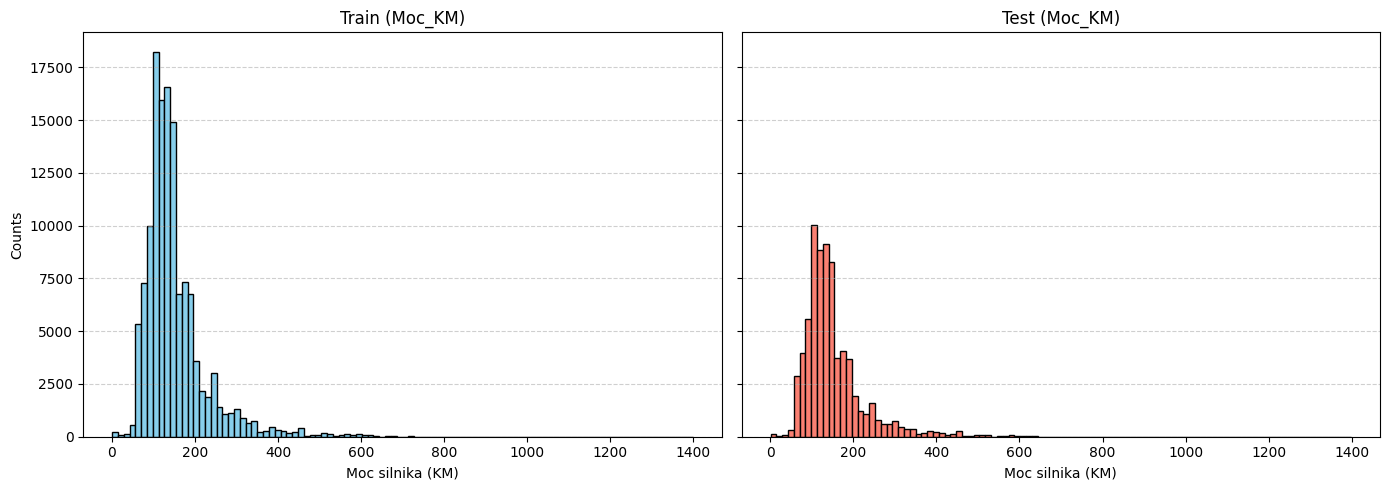

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(df_original_rok["Moc_KM"].dropna(), bins=100, color='skyblue', edgecolor='black')
axes[0].set_title("Train (Moc_KM)")
axes[0].set_xlabel("Moc silnika (KM)")
axes[0].set_ylabel("Counts")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].hist(df_test_rok["Moc_KM"].dropna(), bins=100, color='salmon', edgecolor='black')
axes[1].set_title("Test (Moc_KM)")
axes[1].set_xlabel("Moc silnika (KM)")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


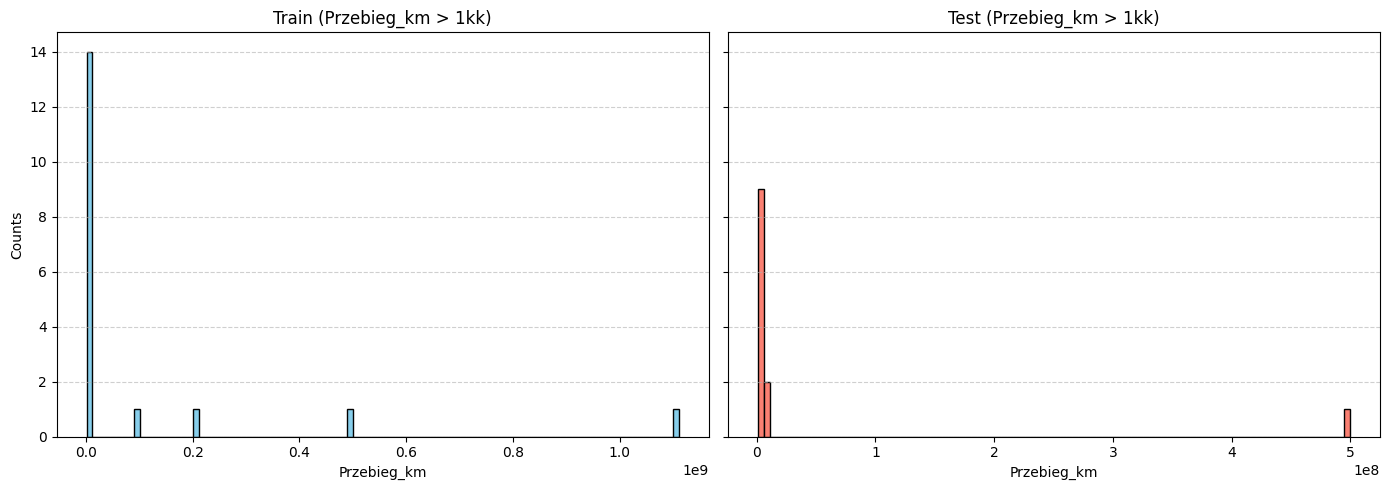

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(
    df_original_rok.loc[df_original_rok["Przebieg_km"] > 1000000, "Przebieg_km"].dropna(),
    bins=100,
    color='skyblue',
    edgecolor='black'
)
axes[0].set_title("Train (Przebieg_km > 1kk)")
axes[0].set_xlabel("Przebieg_km")
axes[0].set_ylabel("Counts")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].hist(
    df_test_rok.loc[df_test_rok["Przebieg_km"] > 1000000, "Przebieg_km"].dropna(),
    bins=100,
    color='salmon',
    edgecolor='black'
)
axes[1].set_title("Test (Przebieg_km > 1kk)")
axes[1].set_xlabel("Przebieg_km")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


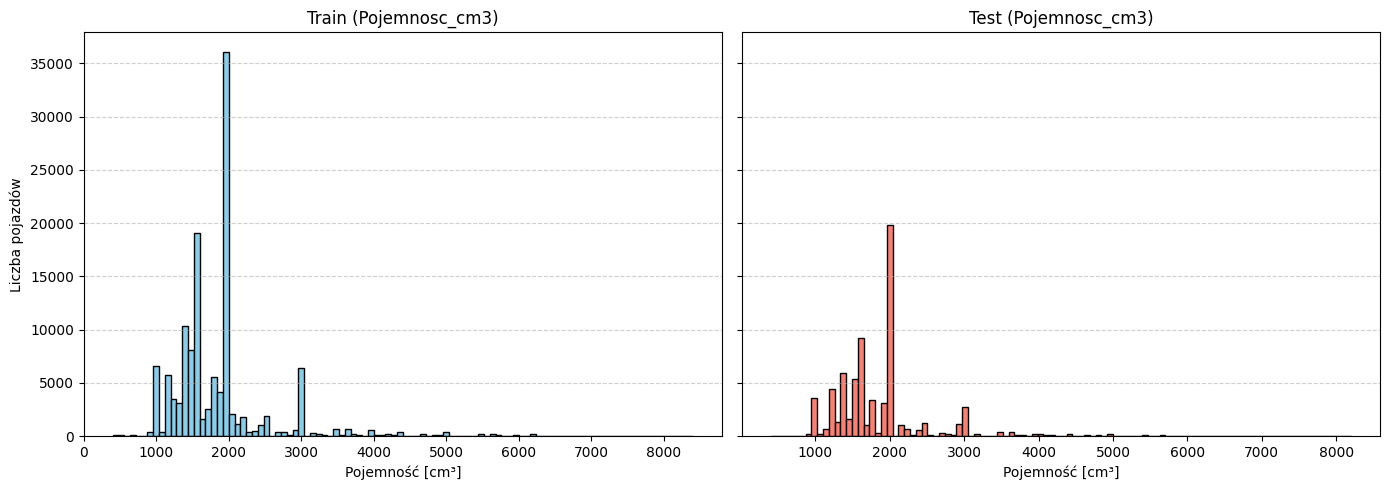

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(df_original_rok["Pojemnosc_cm3"].dropna(), bins=100, color='skyblue', edgecolor='black')
axes[0].set_title("Train (Pojemnosc_cm3)")
axes[0].set_xlabel("Pojemność [cm³]")
axes[0].set_ylabel("Liczba pojazdów")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].hist(df_test_rok["Pojemnosc_cm3"].dropna(), bins=100, color='salmon', edgecolor='black')
axes[1].set_title("Test (Pojemnosc_cm3)")
axes[1].set_xlabel("Pojemność [cm³]")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [206]:
df_original_rok["Duza_pojemnosc"] = (df_original_rok["Pojemnosc_cm3"] > 4000).astype(int)
df_test_rok["Duza_pojemnosc"] = (df_test_rok["Pojemnosc_cm3"] > 4000).astype(int)

print(df_original_rok["Duza_pojemnosc"].value_counts())
print(df_test_rok["Duza_pojemnosc"].value_counts())


Duza_pojemnosc
0    132379
1      3016
Name: count, dtype: int64
Duza_pojemnosc
0    71189
1     1718
Name: count, dtype: int64


In [207]:
df_original_rok["Duza_moc"] = (df_original_rok["Moc_KM"] > 400).astype(int)
df_test_rok["Duza_moc"] = (df_test_rok["Moc_KM"] > 400).astype(int)

print("Train:")
print(df_original_rok["Duza_moc"].value_counts())
print("\nTest:")
print(df_test_rok["Duza_moc"].value_counts())


Train:
Duza_moc
0    133002
1      2393
Name: count, dtype: int64

Test:
Duza_moc
0    71524
1     1383
Name: count, dtype: int64


In [208]:
df_original_rok["Nowy_pojazd"] = (df_original_rok["Rok_produkcji"] >= 1980).astype(int)
df_test_rok["Nowy_pojazd"] = (df_test_rok["Rok_produkcji"] >= 1980).astype(int)

print("Train:")
print(df_original_rok["Nowy_pojazd"].value_counts())
print("\nTest:")
print(df_test_rok["Nowy_pojazd"].value_counts())


Train:
Nowy_pojazd
1    133768
0      1627
Name: count, dtype: int64

Test:
Nowy_pojazd
1    72567
0      340
Name: count, dtype: int64


# XGboost

### Choosing columns

In [209]:
columns_to_check = [
    'Rok_produkcji',
    'Przebieg_km',
    'Moc_KM',
    'Pojemnosc_cm3',
    'Waluta',
    'Stan',
    'Model_pojazdu_encoded',
    'Marka_pojazdu_encoded',
    'Naped_encoded',
    'Generacja_pojazdu_encoded',
    'Emisja_CO2',
    'Moc_do_Pojemnosc',
    'Pojemnosc_bin',
    'Moc_bin',
    'Skrzynia_biegow_Manual',
    'Skrzynia_biegow_Automatic',
    'Pierwszy_wlasciciel',
    'Duza_pojemnosc',
    'Duza_moc',
    'Nowy_pojazd'
]


columns_from_wyposazenie = feature_counts_df["Wyposażenie"].tolist()
columns_to_check_extended = columns_to_check + columns_from_wyposazenie


wojewodztwo_cols = [col for col in df_original_lokalizacja.columns if col.startswith("woj_")]


columns_to_check_extended += wojewodztwo_cols


columns_to_check = columns_to_check_extended


In [210]:
dataset = df_original_rok.copy()

### Action

In [211]:
df_train = dataset.copy()
y = df_train['Cena']
X = df_train.drop(['Cena'], axis = 1)

In [212]:
X = X[columns_to_check]

In [213]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

y_train_full = np.log1p(y_train_full)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.5, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [214]:
print(X_test.shape)
print(y_test.shape)


(40619, 108)
(40619,)


In [215]:
import os
import random
import numpy as np


SEED = 1


import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 5000)

    params = {
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse',
      'booster': 'gbtree',
      'eta': trial.suggest_float('eta', 0.005, 0.05),
      'max_depth': trial.suggest_int('max_depth', 6, 20),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 7),
      'gamma': trial.suggest_float('gamma', 0.0, 0.05),
      'subsample': trial.suggest_float('subsample', 0.4, 0.8),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
      'lambda': trial.suggest_float('lambda', 1e-7, 1e-3, log=True),
      'alpha': trial.suggest_float('alpha', 1e-7, 1e-3, log=True),
      'device': 'cuda',
      'seed': SEED,
      'verbosity': 0

    }

    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=n_estimators,
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = bst.predict(dvalid, iteration_range=(0, bst.best_iteration))
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

study.optimize(objective, n_trials=10)

print("Najlepsze hiperparametry:", study.best_params)
print("Najlepszy wynik (RMSE):", study.best_value)

X_train_merged = pd.concat([X_train, X_val])
y_train_merged = pd.concat([y_train, y_val])
dtrain_merged = xgb.DMatrix(X_train_merged, label=y_train_merged)

final_params = study.best_params.copy()
best_n_estimators = final_params.pop('n_estimators')
final_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'device': 'cuda',
    'seed': SEED,
    'verbosity': 0
})

final_model = xgb.train(
    final_params,
    dtrain_merged,
    num_boost_round=best_n_estimators,
    verbose_eval=False
)

final_preds = final_model.predict(dtest, iteration_range=(0, best_n_estimators))
print("Final predictions (log scale):", final_preds)

final_preds_original = np.expm1(final_preds)
print("Final predictions (original scale):", final_preds_original)

rmse_test = np.sqrt(mean_squared_error(y_test, final_preds_original))
print("RMSE on test set:", rmse_test)


[I 2025-03-26 19:13:25,664] A new study created in memory with name: no-name-5836ce13-6599-4bfe-b49c-b9226d54ed5f
[I 2025-03-26 19:14:33,368] Trial 0 finished with value: 0.24503174615735734 and parameters: {'n_estimators': 2143, 'eta': 0.03741460220489712, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.007337794540855653, 'subsample': 0.43693543790751915, 'colsample_bytree': 0.4372520422755342, 'lambda': 2.41125370614757e-06, 'alpha': 3.864291653552648e-06}. Best is trial 0 with value: 0.24503174615735734.
[I 2025-03-26 19:15:31,685] Trial 1 finished with value: 0.2462616907400516 and parameters: {'n_estimators': 2740, 'eta': 0.02386375314814827, 'max_depth': 16, 'min_child_weight': 3, 'gamma': 0.043905871819547276, 'subsample': 0.4109550372791705, 'colsample_bytree': 0.5340935020356804, 'lambda': 4.66894985370889e-06, 'alpha': 1.716956585247387e-05}. Best is trial 0 with value: 0.24503174615735734.
[I 2025-03-26 19:16:56,029] Trial 2 finished with value: 0.24440310883255345 and pa

Najlepsze hiperparametry: {'n_estimators': 3464, 'eta': 0.042558155235381784, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.049443054445324736, 'subsample': 0.6992662617519358, 'colsample_bytree': 0.456088798412881, 'lambda': 0.0001435877247343462, 'alpha': 2.587641015421048e-07}
Najlepszy wynik (RMSE): 0.2424603028506845
Final predictions (log scale): [ 9.913712  11.107907  10.5417595 ... 10.420573   9.810068   9.057702 ]
Final predictions (original scale): [20204.53  66695.47  37863.13  ... 33541.656 18215.229  8583.401]
RMSE on test set: 23295.3557603227


### Final prediction based on best hyperparameters

In [216]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

y_train_full_log = np.log1p(y)

dtrain_full = xgb.DMatrix(X, label=y_train_full_log)

dtest = xgb.DMatrix(df_test_rok[columns_to_check])

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'eta': 0.015585502897414984,
    'max_depth': 8,
    'min_child_weight': 3,
    'gamma': 0.014398001187365343,
    'subsample': 0.5725110488549374,
    'colsample_bytree': 0.4086665476849841,
    'lambda': 4.745204180610975e-06,
    'alpha': 2.5350801304973753e-05,
    'device': 'cuda',
    'seed': 42
}

final_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=4544,
    verbose_eval=False
)

final_preds_log = final_model.predict(dtest)
final_preds_original_scale = np.expm1(final_preds_log)


print("Final prediction:", final_preds_original_scale)

Final prediction: [198451.33   20175.01   19694.707 ...  65550.625  25972.402 194391.44 ]


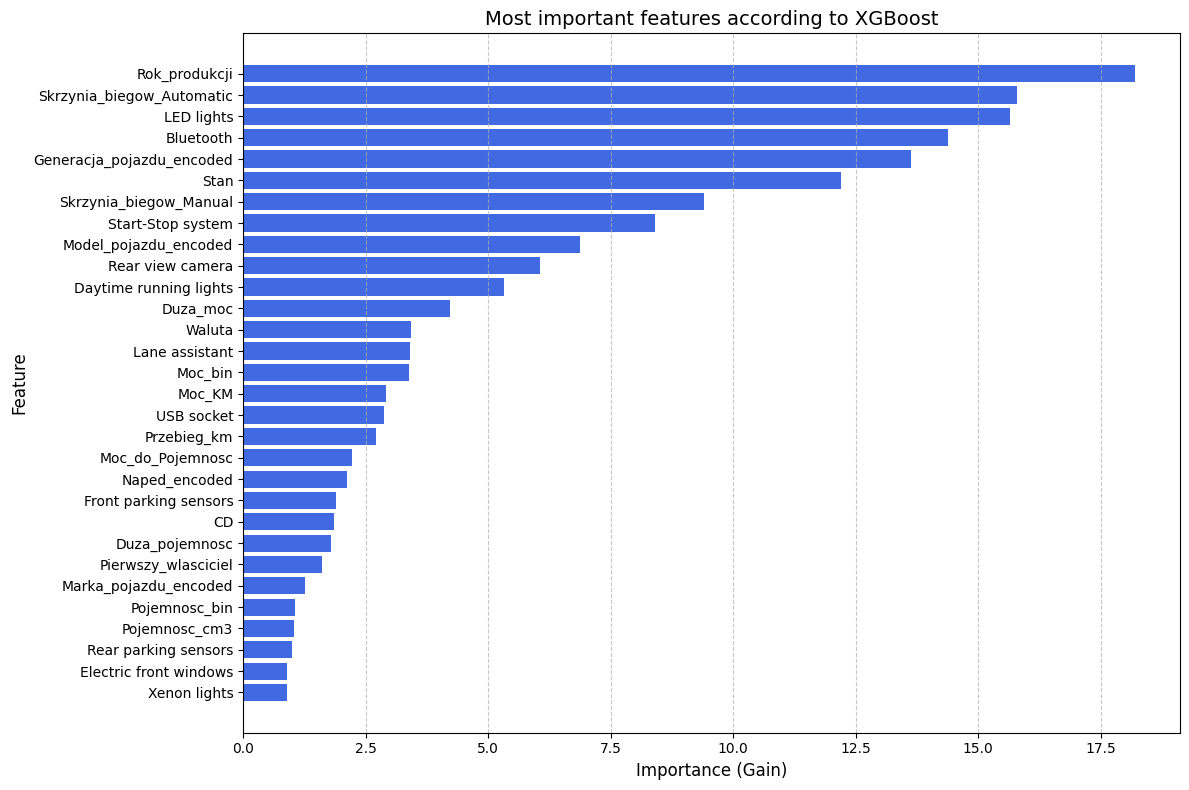

In [217]:
import matplotlib.pyplot as plt
import pandas as pd

importance = final_model.get_score(importance_type='gain')

importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

top_n = 30
importance_df_top = importance_df.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(importance_df_top['Feature'], importance_df_top['Importance'], color='royalblue')
plt.xlabel("Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Most important features according to XGBoost", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [218]:
df_predictions = pd.DataFrame({
    "ID": df_test_naped["ID"].values,
    "Cena": final_preds_original_scale
})

print(df_predictions.head())

df_predictions.to_csv("predictions.csv", index=False)


   ID           Cena
0   1  198451.328125
1   2   20175.009766
2   3   19694.707031
3   4  103765.765625
4   5   88544.312500
